## Clustering Orange survey data with K-Means, DBSCAN and Louvain method

First we read the data and preprocess it for later use. We can remove few unrelavent atributes like: "Start Date (UTC)", "Submit Date (UTC)", "Network ID", "#", "Other", "Other.1", "Other.2", "Other.3". All atributes in data are optional, that means that there are only a few different values in each column. If we can look at columns "Excel", "IBM SPSS Statistics", "KNIME", "MATLAB", "Python", "Python Pandas", "R", "Rapid Miner","SQL", "Weka","None", we can see that this columns structure can be changed to binary form.   


In [8]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN,KMeans
from sklearn.metrics import silhouette_samples, silhouette_score,davies_bouldin_score, cohen_kappa_score
import community
import networkx as nx
from sklearn import metrics
import sklearn.neighbors as sk
import numpy as np


In [33]:
data = pd.read_csv("../data/Orange questionnaire.csv")

# drop all unrelavant atributes
data = data.drop("#", axis=1)
data = data.drop("Other", axis=1)
data = data.drop("Other.1", axis=1)
data = data.drop("Other.2", axis=1)
data = data.drop("Other.3", axis=1)
data = data.drop("Start Date (UTC)", axis=1)
data = data.drop("Submit Date (UTC)", axis=1)
data = data.drop("Network ID", axis=1)
# change columns from index 3 to 14 to binary values and calculate their frequency
data = data.sample(n=1000)
for n in range(3, 15):
    data.iloc[:, n] = (~data.iloc[:, n].isnull()).astype(int)
    
original = data.copy(deep=False)
for n in range(3, 15):
    tmp = (data.iloc[:, n].value_counts()/len(data)).to_dict()
    data.iloc[:, n] = data.iloc[:, n].replace(tmp)





#### Data analysis and visualization

Here we represent each atribute, so we can see how many of each values are in it. Then we use t-SNE method for dimension reduction, so we can visualize multidimensional data in 2D space. We use t-SNE with different paramters, so we can se the difference how structure changes.

In [53]:
for a in original:
    print(original[a].value_counts()/len(original),"\n")

Web           0.319
Anaconda      0.256
College       0.132
School        0.087
Friends       0.065
Job           0.048
Conference    0.022
Name: Where did you find out about Orange?, dtype: float64 

Beginner        0.668
Intermediate    0.246
Expert          0.061
Name: What Data Mining level are you?, dtype: float64 

I'm a student    0.330
Industry         0.272
Academia         0.184
Research         0.130
0                0.084
Name: Where do you work?, dtype: float64 

1    0.606
0    0.394
Name: Excel, dtype: float64 

0    0.9
1    0.1
Name: IBM SPSS Statistics, dtype: float64 

0    0.954
1    0.046
Name: KNIME, dtype: float64 

0    0.811
1    0.189
Name: MATLAB, dtype: float64 

0    0.555
1    0.445
Name: Python, dtype: float64 

0    0.772
1    0.228
Name: Python Pandas, dtype: float64 

0    0.718
1    0.282
Name: R, dtype: float64 

0    0.938
1    0.062
Name: Rapid Miner, dtype: float64 

0    0.67
1    0.33
Name: SQL, dtype: float64 

0    0.885
1    0.115
Name: Weka,

In [34]:
# Replace NaN values with 0 and strings to numbers.
level = {"Expert": 3, "Beginner": 1, "Intermediate": 2, 0: 0, "NaN": 0}

job = {"Academia": 3, "Research": 1, "I'm a student": 2, 0: 0, "Industry": 4}

find_out = {"College": 1, "Conference": 2, "Web": 3, "Friends": 4, "School": 5, "Job": 6, "Anaconda": 7, 0: 0}


data["Where do you work?"] = data["Where do you work?"].fillna(0)
data["Where do you work?"] = data["Where do you work?"].replace(job)


data["What Data Mining level are you?"] = data["What Data Mining level are you?"].fillna(0)
data["What Data Mining level are you?"] = data["What Data Mining level are you?"].replace(level)

data["Where did you find out about Orange?"] = data["Where did you find out about Orange?"].fillna(0)
data["Where did you find out about Orange?"] = data["Where did you find out about Orange?"].replace(find_out)




In [35]:
# print(data.head())
# print(data["What Data Mining level are you?"].value_counts()/len(data))
level_freq = (data["What Data Mining level are you?"].value_counts()/len(data)).to_dict()

job_freq = (data["Where do you work?"].value_counts()/len(data)).to_dict()

find_out_freq = (data["Where did you find out about Orange?"].value_counts()/len(data)).to_dict()

data["What Data Mining level are you?"] = data["What Data Mining level are you?"].replace(level_freq)
data["Where do you work?"] = data["Where do you work?"].replace(job_freq)
data["Where did you find out about Orange?"] = data["Where did you find out about Orange?"].replace(find_out_freq)

for column in data:
    data[column] = data[column].fillna(0)


In [38]:
data_2D = TSNE(n_components=2, perplexity=10).fit_transform(data)

Text(0.5,1,'T-SNE')

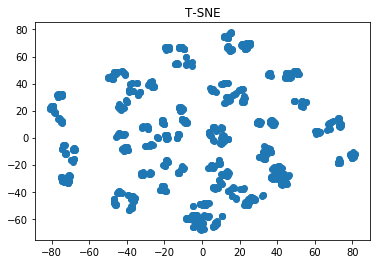

In [39]:
plt.scatter(data_2D[:, 0], data_2D[:, 1])
plt.title("T-SNE")

Here we try different perplexity number, so we can see how it effects structure of data.

In [40]:
data_2D_5 = TSNE(n_components=2, perplexity=5).fit_transform(data)

In [41]:
data_2D_30 = TSNE(n_components=2, perplexity=30).fit_transform(data)

In [42]:
data_2D_50 = TSNE(n_components=2, perplexity=50).fit_transform(data)

In [43]:
data_2D_100 = TSNE(n_components=2, perplexity=500).fit_transform(data)

Text(0.5,1,'T-SNE-5')

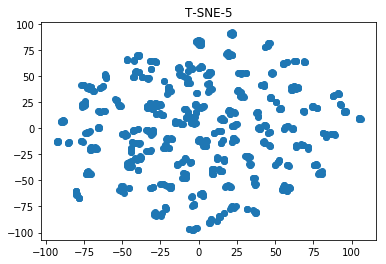

In [44]:
plt.scatter(data_2D_5[:, 0], data_2D_5[:, 1])
plt.title("T-SNE-5")

Text(0.5,1,'T-SNE-30')

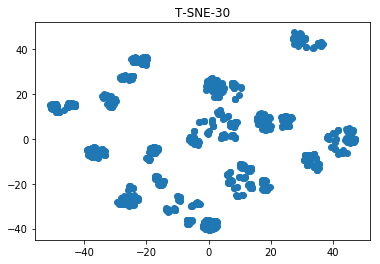

In [45]:
plt.scatter(data_2D_30[:, 0], data_2D_30[:, 1])
plt.title("T-SNE-30")

Text(0.5,1,'T-SNE-50')

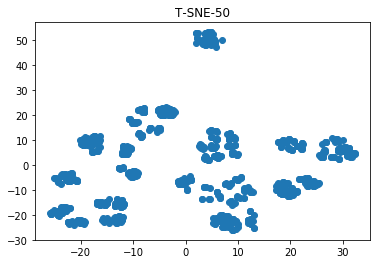

In [46]:
plt.scatter(data_2D_50[:, 0], data_2D_50[:, 1])
plt.title("T-SNE-50")

Text(0.5,1,'T-SNE-500')

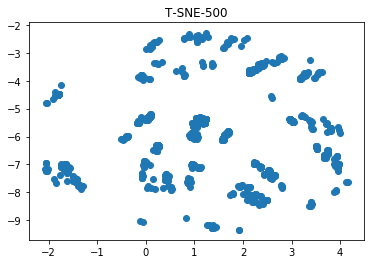

In [47]:
plt.scatter(data_2D_100[:, 0], data_2D_100[:, 1])
plt.title("T-SNE-500")


### Clustering with k-MEANS method

Here we preform clustering on data with k-MEANS method. 

In [48]:
test = data

With elbow method, we try to figure out the optimal number of clusters, but later we check the quality of clustering with silhouette score.

Text(0,0.5,'WCSS')

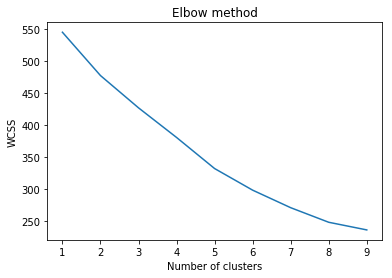

In [49]:
k_means_results = []
for n_clusters in range(1,10):
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(test)
    k_means_results.append(clusterer.inertia_)
plt.plot(range(1,10),k_means_results)
plt.title("Elbow method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")

In [50]:
results = {}
for n_clusters in range(2,10):
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    cluster_labels = clusterer.fit_predict(test)
    silhouette_avg = silhouette_score(test, cluster_labels)
#     print(davies_bouldin_score(test, cluster_labels)," -bouldin")
    print(silhouette_avg," -silhouette")
    results[n_clusters] = cluster_labels

0.301842820562  -silhouette
0.28564563388  -silhouette
0.223714121033  -silhouette
0.270341721653  -silhouette
0.272571095468  -silhouette
0.279655480445  -silhouette
0.263783640686  -silhouette
0.266932306277  -silhouette


In [51]:
original['clusters'] = pd.Series(results[3], index=original.index)

In [52]:
test2 = original.groupby(['clusters'])
for cluster in test2:
    for column in cluster[1]:
        print(cluster[0],"\n",cluster[1][column].value_counts()/len(cluster[1]),"\n")




0 
 Web           0.367816
Anaconda      0.218391
College       0.114943
School        0.103448
Friends       0.068966
Job           0.057471
Conference    0.022989
Name: Where did you find out about Orange?, dtype: float64 

0 
 Beginner        0.609195
Intermediate    0.287356
Expert          0.080460
Name: What Data Mining level are you?, dtype: float64 

0 
 Industry         0.310345
I'm a student    0.264368
Academia         0.206897
Research         0.149425
0                0.068966
Name: Where do you work?, dtype: float64 

0 
 1    0.816092
0    0.183908
Name: Excel, dtype: float64 

0 
 1    1.0
Name: IBM SPSS Statistics, dtype: float64 

0 
 0    0.954023
1    0.045977
Name: KNIME, dtype: float64 

0 
 0    0.83908
1    0.16092
Name: MATLAB, dtype: float64 

0 
 0    0.574713
1    0.425287
Name: Python, dtype: float64 

0 
 0    0.816092
1    0.183908
Name: Python Pandas, dtype: float64 

0 
 0    0.528736
1    0.471264
Name: R, dtype: float64 

0 
 0    0.885057
1    0.1149

In [468]:
data_2d_test = TSNE(n_components=2, perplexity=10).fit_transform(test)


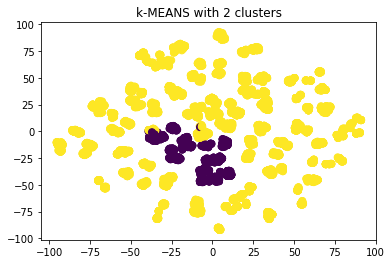

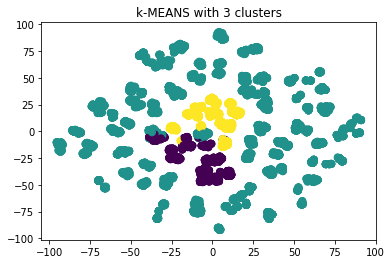

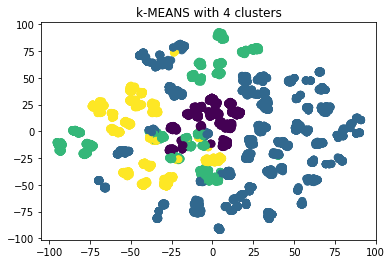

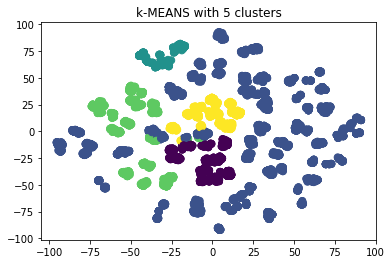

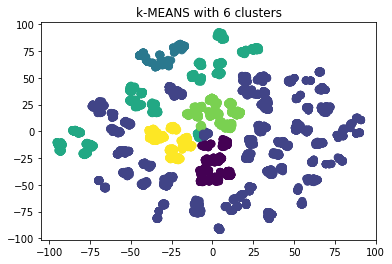

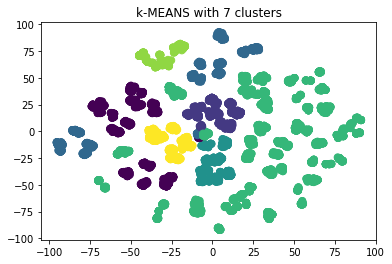

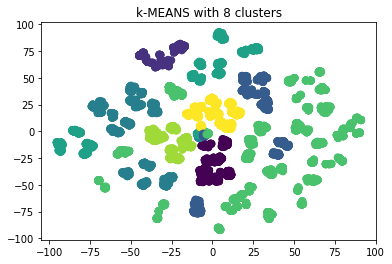

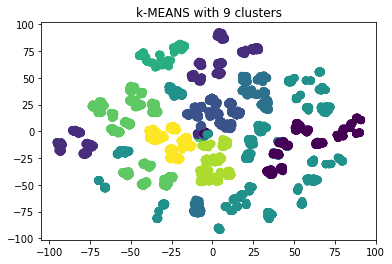

In [301]:
for clusters in results:
    plt.figure()
    plt.scatter(data_2d_test[:, 0], data_2d_test[:, 1], c=results[clusters], s=50, cmap='viridis')
    plt.title("k-MEANS with "+str(clusters)+" clusters")


### Clustering with DBSCAN method

Here we preform clustering on data with DBSCAN method. With elbow method, we try to figure out the optimal parameter eps. The results of clustering are rated with the silhouette score.

In [13]:
# this is the function that returns the distance to k-th neighbour
def k_dist(X, metric, k=3):
        data = []
        tree = sk.KDTree(X, leaf_size=30)
        for n,point in enumerate(X):
            dist, ind = tree.query([point], k=k)
            data.append(dist[0].tolist()[k-1])
        return data

Here we preform the elbow method, so we can try to find out the optimal parameter eps.

In [17]:
X_2 = TSNE(n_components=2 , perplexity=10).fit_transform(test)


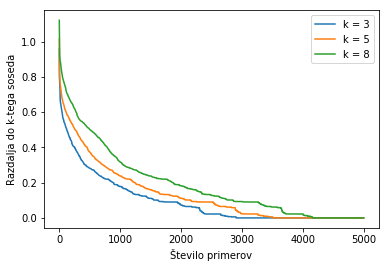

In [27]:
K_2 = k_dist(test.values, '', 3)
K_3 = k_dist(test.values, '', 5)
K_8 = k_dist(test.values, '', 10)
# print(sorted(K_2, reverse=True))
# print(sorted(K_3, reverse=True))
# print(sorted(K_8, reverse=True))
plt.plot(sorted(K_2, reverse=True))
plt.plot(sorted(K_3, reverse=True))
plt.plot(sorted(K_8, reverse=True))
plt.legend(["k = 3", "k = 5", "k = 8"])
plt.xlabel('Število primerov')
plt.ylabel('Razdalja do k-tega soseda')
plt.show()

In [32]:
# X_2 = TSNE(n_components=2 , perplexity=30).fit_transform(test)
db = DBSCAN(eps=0.8, min_samples=8).fit(test)
labels = db.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(test, labels))


Estimated number of clusters: 5
Estimated number of noise points: 7
Silhouette Coefficient: 0.289


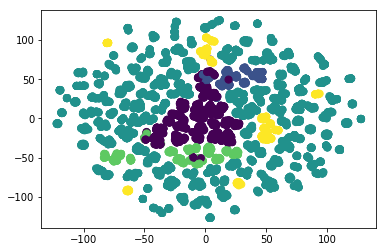

In [18]:
plt.scatter(X_2[:, 0], X_2[:, 1], c=labels, s=50, cmap='viridis')

### Comparing clustering results

Comparing clustering results from DBSCAN and k-MEANS methods, using Kappa index.

In [466]:
print("DBSCAN - 3 clusters with 18 noise points\nk-MEANS - 2 clusters\n",cohen_kappa_score(labels, results[2]))

DBSCAN - 3 clusters with 18 noise points
k-MEANS - 2 clusters
 0.0153023453054


### Clustering with Louvain method

In [11]:
# Replace this with your networkx graph loading depending on your format !
# G=nx.from_pandas_dataframe(test, 0)
G = nx.from_pandas_dataframe(test,source='from',
                                   target='to',edge_attr=True,
                                   create_using=nx.DiGraph())

#first compute the best partition
partition = community.best_partition(G)

AttributeError: module 'networkx' has no attribute 'from_pandas_dataframe'